In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import json
import os
from os.path import dirname, join
from pdb import set_trace

import jupytools
import jupytools.syspath
import pandas as pd

jupytools.syspath.add(join(dirname(os.getcwd()), 'protein_project'))
jupytools.syspath.add('rxrx1-utils')
if jupytools.is_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm as tdqm
    
import contextlib, io
with contextlib.redirect_stderr(io.StringIO()):
    from augmentation import Augmented, multichannel_norm
    from basedir import ROOT
    from dataset import load_data, RxRxDataset
    from visual import rgb, six, show_1, show

In [3]:
data_dict = load_data()
train_dataset, _ = data_dict['data']
train_dataset[:1]

[{'id_code': 'HEPG2-01_1_B03',
  'site': 1,
  'channel': 1,
  'cell_type': 'HEPG2',
  'experiment': 'HEPG2-01',
  'plate': 1,
  'sirna': 513,
  'well': 'B03',
  'well_type': 'treatment',
  'images': [[1, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w1.png'],
   [2, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w2.png'],
   [3, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w3.png'],
   [4, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w4.png'],
   [5, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w5.png'],
   [6, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w6.png']],
  'enc_sirna': 513}]

In [4]:
with open('channels.json') as f:
    stats = json.load(f)

In [5]:
stats[0]

{'id_code': 'HEPG2-01_1_B02',
 'site': 1,
 'stats': [{'channel': 1,
   'mean': 71.06378173828125,
   'std': 43.14624020359442,
   'min': 7,
   'max': 255},
  {'channel': 2,
   'mean': 32.17443084716797,
   'std': 9.384593881566696,
   'min': 6,
   'max': 98},
  {'channel': 3,
   'mean': 61.83602523803711,
   'std': 23.377996776448498,
   'min': 11,
   'max': 255},
  {'channel': 4,
   'mean': 56.98325729370117,
   'std': 16.011434941156928,
   'min': 11,
   'max': 156},
  {'channel': 5,
   'mean': 91.67199325561523,
   'std': 39.22183623140293,
   'min': 13,
   'max': 255},
  {'channel': 6,
   'mean': 49.6343879699707,
   'std': 15.679836349193573,
   'min': 10,
   'max': 255}]}

In [6]:
def pull_key(records, key, no_duplicates=True):
    stacked = {}
    if isinstance(key, str):
        key = [key]
        
    def extract_key(record, key):
        reference = []
        for part in key:
            if part not in record:
                print(f'Record #{i}: the key is "{part}" missing.')
                return None
            reference.append(record.pop(part))
        return tuple(reference)
    
    for i, record in enumerate(records):
        reference = extract_key(record, key)
        if reference is None:
            continue
        if reference in stacked and no_duplicates:
            raise ValueError(f'key value is duplicated: {reference}')
        stacked[reference] = record
    return stacked

In [7]:
train_dataset_index = pull_key(train_dataset, ['id_code', 'site'])

In [8]:
train_stats_index = pull_key(stats, ['id_code', 'site'])

In [9]:
list(train_dataset_index.keys())[:3]

[('HEPG2-01_1_B03', 1), ('HEPG2-01_1_B03', 2), ('HEPG2-01_1_B04', 1)]

In [10]:
key = ('HEPG2-01_1_B03', 1)

In [11]:
x = train_dataset_index[key]
x

{'channel': 1,
 'cell_type': 'HEPG2',
 'experiment': 'HEPG2-01',
 'plate': 1,
 'sirna': 513,
 'well': 'B03',
 'well_type': 'treatment',
 'images': [[1, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w1.png'],
  [2, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w2.png'],
  [3, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w3.png'],
  [4, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w4.png'],
  [5, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w5.png'],
  [6, '/home/ck/data/protein/train/HEPG2-01/Plate1/B03_s1_w6.png']],
 'enc_sirna': 513}

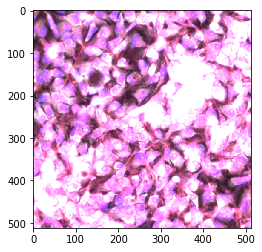

In [12]:
show_1(six(x))

In [13]:
x_norm = multichannel_norm(
    six(train_dataset_index[key]).astype(float),
    stats=train_stats_index[key]['stats']
)

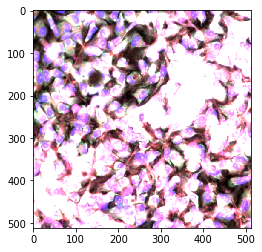

In [14]:
show_1(x_norm * 255)

In [15]:
experiments = sorted(set([record['experiment'] for record in train_dataset]))

In [16]:
train_df = pd.DataFrame(train_dataset)

In [17]:
samples = (
    train_df
    .groupby('experiment', as_index=False)
    .apply(lambda g: g.sample(1))
    .reset_index(drop=True))

In [18]:
samples

,cell_type,channel,enc_sirna,experiment,images,plate,sirna,well,well_type
0,HEPG2,1,959,HEPG2-01,"[[1, /home/ck/data/protein/train/HEPG2-01/Plat...",1,959,L11,treatment
1,HEPG2,1,919,HEPG2-02,"[[1, /home/ck/data/protein/train/HEPG2-02/Plat...",3,919,O13,treatment
2,HEPG2,1,864,HEPG2-03,"[[1, /home/ck/data/protein/train/HEPG2-03/Plat...",3,864,I02,treatment
3,HEPG2,1,329,HEPG2-04,"[[1, /home/ck/data/protein/train/HEPG2-04/Plat...",2,329,E18,treatment
4,HEPG2,1,856,HEPG2-05,"[[1, /home/ck/data/protein/train/HEPG2-05/Plat...",4,856,E04,treatment
5,HEPG2,1,789,HEPG2-06,"[[1, /home/ck/data/protein/train/HEPG2-06/Plat...",2,789,E03,treatment
6,HEPG2,1,156,HEPG2-07,"[[1, /home/ck/data/protein/train/HEPG2-07/Plat...",4,156,O20,treatment
7,HUVEC,1,496,HUVEC-01,"[[1, /home/ck/data/protein/train/HUVEC-01/Plat...",4,496,E06,treatment
8,HUVEC,1,35,HUVEC-02,"[[1, /home/ck/data/protein/train/HUVEC-02/Plat...",3,35,J21,treatment
9,HUVEC,1,731,HUVEC-03,"[[1, /home/ck/data/protein/train/HUVEC-03/Plat...",2,731,G06,treatment


In [19]:
records = samples[['experiment', 'enc_sirna', 'images']].to_dict('records')
experiments = [r['experiment'] for r in records]
sirnas = [str(r['enc_sirna']) for r in records]
titles = ['/'.join(pair) for pair in zip(experiments, sirnas)]
images = [six(r) for r in tqdm(records)]

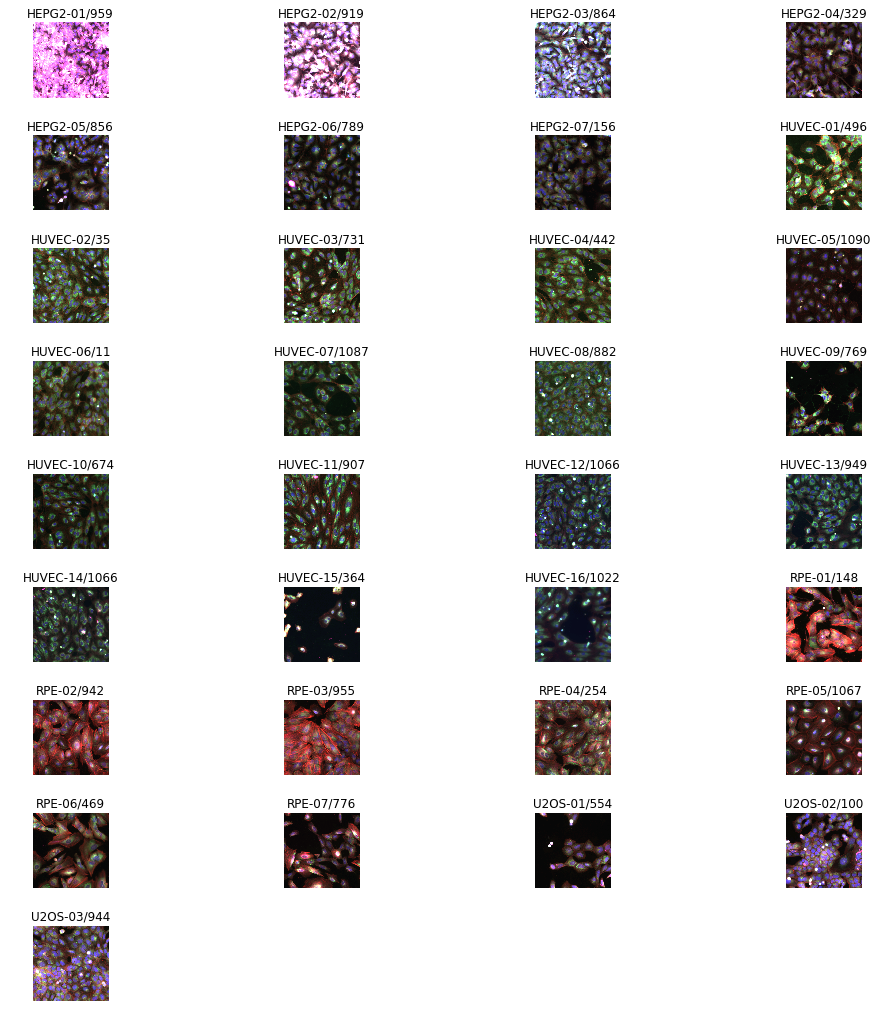

In [20]:
show(*images, titles=titles);

In [59]:
# show(six({'images': samples.images[0]}));

In [21]:
import cv2 as cv

In [58]:
img = images[10]

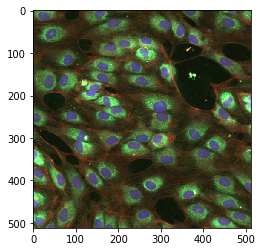

In [60]:
show_1(img)

In [65]:
cv.equalizeHist(img[0:3, :, :])

error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/histogram.cpp:3345: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'equalizeHist'


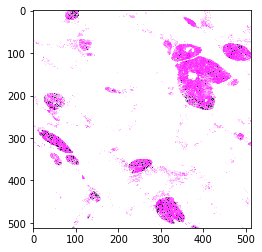

In [59]:
show_1(np.stack([cv.equalizeHist(img[i]) for i in range(6)]))